In [1]:
import torch
import torch.nn as nn
import numpy as np
import h5py
import os

encoding = ['N', 'R', 'A', 'x', 'V', '~', '+']

class NSTDB(torch.utils.data.Dataset):
    def __init__(self):
        self.h5_list = []
        for root, dirs, files in os.walk('../data'):
            for f in files:
                path = os.path.join(root, f)
                with h5py.File(path, 'r') as h5:
                    if h5['MLII'][:].size == 0:
                        continue
                    if h5['V1'][:].size == 0:
                        continue
                    if h5['SNR'][()] == 'no':
                        continue
                self.h5_list.append(os.path.join(root, f))
        
    def __getitem__(self, index):
        with h5py.File(self.h5_list[index], 'r') as f:
            id_ = f['id'][()]
            MLII = torch.tensor(f['MLII'][:])
            V1 = torch.tensor(f['V1'][:])
            label = torch.tensor(encoding.index(f['label'][()]))
            SNR = f['SNR'][()]
            return {
                'id': id_,
                'MLII': MLII.float(),
                'V1': V1.float(),
                'label': label,
                'SNR': SNR
            }
    def __len__(self):
        return len(self.h5_list)
dataset = NSTDB()

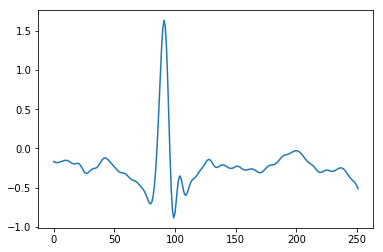

Label: tensor(0)
SNR: 24


In [10]:
import matplotlib.pyplot as plt
id_, MLII, V1, label, SNR = dataset[10000].values()
plt.plot(range(len(MLII)), MLII)
plt.show()
print('Label:', label)
print('SNR:', SNR)

In [3]:
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [int(0.7*len(dataset)), len(dataset)-int(0.7*len(dataset))])
print(len(dataset_train), len(dataset_val))
from torch.utils.data import DataLoader
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

7996 3428


In [4]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv1d(1, 32, 3),
#             nn.ReLU(),
#             nn.BatchNorm1d(32),
#             nn.Conv1d(32, 64, 3),
#             nn.ReLU(),
#             nn.BatchNorm1d(64),
#             nn.Conv1d(64, 128, 3),
#         )
        self.fc = nn.Sequential(
            nn.Linear(504, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 7)
        )
    def forward(self, x):
        x = self.fc(x)
        return x
model = ConvModel().cuda()

In [5]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [6]:
def train(input_data, model, criterion, optimizer):
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for data in input_data:
        id_, MLII, V1, label, SNR = data['id'], data['MLII'].cuda(), data['V1'].cuda(), data['label'].cuda(), data['SNR']
        
        optimizer.zero_grad()
        out = model(torch.cat((MLII, V1), 1))
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(out, 1)
        total_count += label.shape[0]
        acc_count += (pred == label).sum().item()
        loss_list.append(loss.item())
        
    acc = acc_count/total_count
    loss = sum(loss_list)/len(loss_list)
    return acc, loss

In [7]:
def val(input_data, model, criterion):
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for data in input_data:
            id_, MLII, V1, label, SNR = data['id'], data['MLII'].cuda(), data['V1'].cuda(), data['label'].cuda(), data['SNR']

            optimizer.zero_grad()
            out = model(torch.cat((MLII, V1), 1))
            loss = criterion(out, label)

            _, pred = torch.max(out, 1)
            total_count += label.shape[0]
            acc_count += (pred == label).sum().item()
            loss_list.append(loss.item())
        
    acc = acc_count/total_count
    loss = sum(loss_list)/len(loss_list)
    return acc, loss

In [8]:
max_epochs = 50
log_interval = 1

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

min_loss = 1000000
best_model = None
best_log_vars = None

print("Start training...")
for epoch in range(1, max_epochs+1):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
#     if val_loss < min_loss:
#         min_loss = val_loss
#         best_model = model.state_dict()
#         best_log_vars = (log_var_a, log_var_b)
        
    if epoch % log_interval == 0:
        print('')
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))

Start training...

==================== Epoch 1 ====================
Train Acc: 0.342796 Train Loss: 1.889366
  Val Acc: 0.497083   Val Loss: 1.777218

==================== Epoch 2 ====================
Train Acc: 0.492246 Train Loss: 1.640695
  Val Acc: 0.497083   Val Loss: 1.470845

==================== Epoch 3 ====================
Train Acc: 0.492246 Train Loss: 1.292629
  Val Acc: 0.497083   Val Loss: 1.123432

==================== Epoch 4 ====================
Train Acc: 0.495248 Train Loss: 1.042994
  Val Acc: 0.563886   Val Loss: 0.972834

==================== Epoch 5 ====================
Train Acc: 0.758004 Train Loss: 0.916203
  Val Acc: 0.809802   Val Loss: 0.852532

==================== Epoch 6 ====================
Train Acc: 0.830540 Train Loss: 0.792551
  Val Acc: 0.825846   Val Loss: 0.724730

==================== Epoch 7 ====================
Train Acc: 0.838919 Train Loss: 0.671572
  Val Acc: 0.831680   Val Loss: 0.619579

==================== Epoch 8 ====================


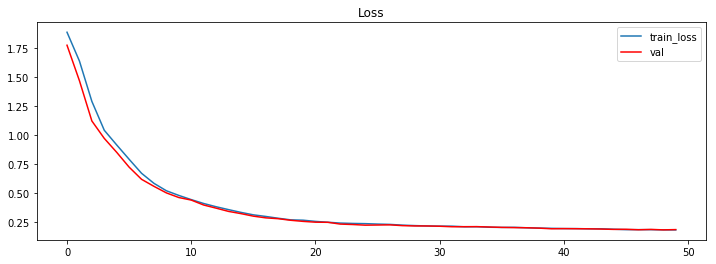

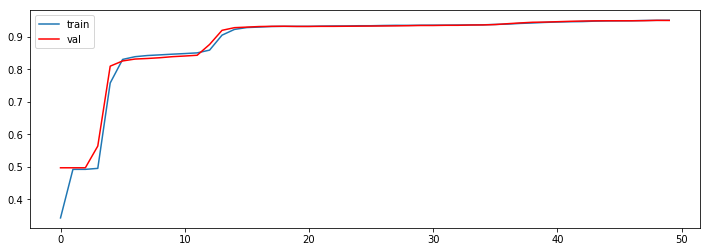

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train_loss', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.show()